# PGE HACKATHON 2022
## Team: NFL - No free Lunch  
- Javier Guerrero
- Viridiana Salazar
- Jason 
- Daniel

### Executive Summary  
For this challenge, we intend to use Machine Learning to predict the location of 3 infill wells and forecast their production for the next 2 years. In order to achieve this, we performed exploratory data analysys of the given datasets. This step included data preparation, feature imputation and feature ranking. Once we narowed down the predictor features for our model, we used a 70/30 train-test split. We decided to use Decision tress because they are one of the most powerful, cutting edge methodology in machine learning and they do not need standarization or normalization.

### WORKFLOW DESCRIPTION  
#### Disclaimer: Most of this workflow has been prepared using code snippets of the workflows designed by Dr. Michael Pyrcz and Dr. John Foster from The University of Texas at Austin. Thank you for all the support

Import Required Packages

In [96]:
import pandas as pd
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from scipy.optimize import curve_fit

import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python  

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score  # specific measures to check our models
from sklearn.model_selection import train_test_split      # train and test split
from sklearn.impute import KNNImputer     # k-nearest neighbour imputation method
from scipy.interpolate import griddata

from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                            # for accessing tree information
from sklearn import metrics                               # measures to check our models
from sklearn.model_selection import cross_val_score       # cross validation methods
from sklearn.tree import export_graphviz                  # graphical visualization of trees


from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import (PolynomialFeatures, MaxAbsScaler, 
                                   MinMaxScaler, StandardScaler, RobustScaler)
from sklearn.linear_model import LinearRegression, ElasticNet 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from scipy import linalg  
from scipy import stats 
# sns.set(rc={'text.usetex' : True})

#### Declare functions

Let's define a couple of functions to streamline plotting correlation matrices and visualization of a machine learning regression model responce over the 2 predictor features.  **Functions written by Dr. Michael Pyrcz**

In [181]:
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,yfeature,response,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return(plt)

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [98]:
well_logs_df = pd.read_csv('Well_logs_base_copy.csv', index_col='Well_ID')
well_logs_df.head()

,X(ft),Y(ft),Completion zone,Completion,Elevation Kelly Bushing (ft),MD (ft),Poro(v/v),Permeability (mD),RHOB(g/cm3),DTS(us/ft),DT(us/ft),PEF(B/E),RD(OHMM),RS(OHMM),ROP,DENC(g/cm3),NPHI(v/v),Zone
Well_ID,,,,,,,,,,,,,,,,,,
Well_0,137106.82,83818.47,0,Upper,193.32,4597.471739,NaN,NaN,2.700700,75.056761,51.232438,6.129957,NaN,NaN,10.710905,0.074251,-0.001900,Upper
Well_0,137106.82,83818.47,0,Upper,193.32,4604.031739,0.087413,NaN,2.819380,85.369586,66.905283,8.498440,NaN,NaN,14.288629,0.088289,0.121538,Upper
Well_0,137106.82,83818.47,0,Upper,193.32,4610.591739,NaN,NaN,2.798909,124.121043,73.454382,9.761416,NaN,NaN,18.420916,0.051770,0.248546,Upper
Well_0,137106.82,83818.47,0,Upper,193.32,4617.151739,0.059590,NaN,2.575396,114.571242,71.776938,5.796872,NaN,NaN,12.595953,0.070758,0.142681,Upper
Well_0,137106.82,83818.47,0,Upper,193.32,4623.711739,NaN,NaN,2.895991,145.921799,62.656075,9.731257,NaN,NaN,22.043198,0.115700,0.353600,Upper


Summary statistics of the dataset

In [4]:
well_logs_df.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
Elevation Kelly Bushing (ft),1963.0,181.281921,9.054317,160.220000,176.490000,181.350000,186.210000,203.850000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),455.0,0.131140,0.062887,0.019566,0.072468,0.129662,0.185373,0.249241
Permeability (mD),221.0,10.497034,39.248645,0.000001,0.019500,0.094813,1.948104,352.697773
RHOB(g/cm3),1918.0,2.472862,0.207148,1.991035,2.326909,2.469486,2.578890,3.044163
DTS(us/ft),1004.0,128.273096,35.222315,-471.675434,116.813090,131.851152,142.295954,186.253964
DT(us/ft),1920.0,80.322722,17.827921,1.138524,69.493418,78.929504,87.863830,179.133001


**Copy df and TRUNCATE Negative values**

In [5]:
wells_df = well_logs_df.copy()
# wells_df.head()
# prevent negative values with truncation
num = wells_df._get_numeric_data()                    # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0
wells_df.describe().transpose()                            # calculate summary statistics for the data


,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
Elevation Kelly Bushing (ft),1963.0,181.281921,9.054317,160.220000,176.490000,181.350000,186.210000,203.850000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),455.0,0.131140,0.062887,0.019566,0.072468,0.129662,0.185373,0.249241
Permeability (mD),221.0,10.497034,39.248645,0.000001,0.019500,0.094813,1.948104,352.697773
RHOB(g/cm3),1918.0,2.472862,0.207148,1.991035,2.326909,2.469486,2.578890,3.044163
DTS(us/ft),1004.0,129.502866,20.175138,0.000000,116.813090,131.851152,142.295954,186.253964
DT(us/ft),1920.0,80.322722,17.827921,1.138524,69.493418,78.929504,87.863830,179.133001


- To improve visualization, we extracted the min and max values of all the features in the dataset

In [6]:
fmin = [100000,80000,0.0,160.0,4200.0,0.0,0.0,1.9,0,1.0,0.0,10,2.0,0.0,0.0,0.0]
fmax = [150000,100000,1.0,210.0,5500.0,0.3,500,3.1,200.0,200.0,12.0,2600.0,65000,50.0,0.25,1.05]

- **Evaluation of Data Coverage**: We can appreciate that porosity and permeability from core measurements presents the highest concentrartion of missing values. This is expected as core data is limited and rutine core analysis is expensive. For the well logs we can appreciate that less than 20% of the data is missing 

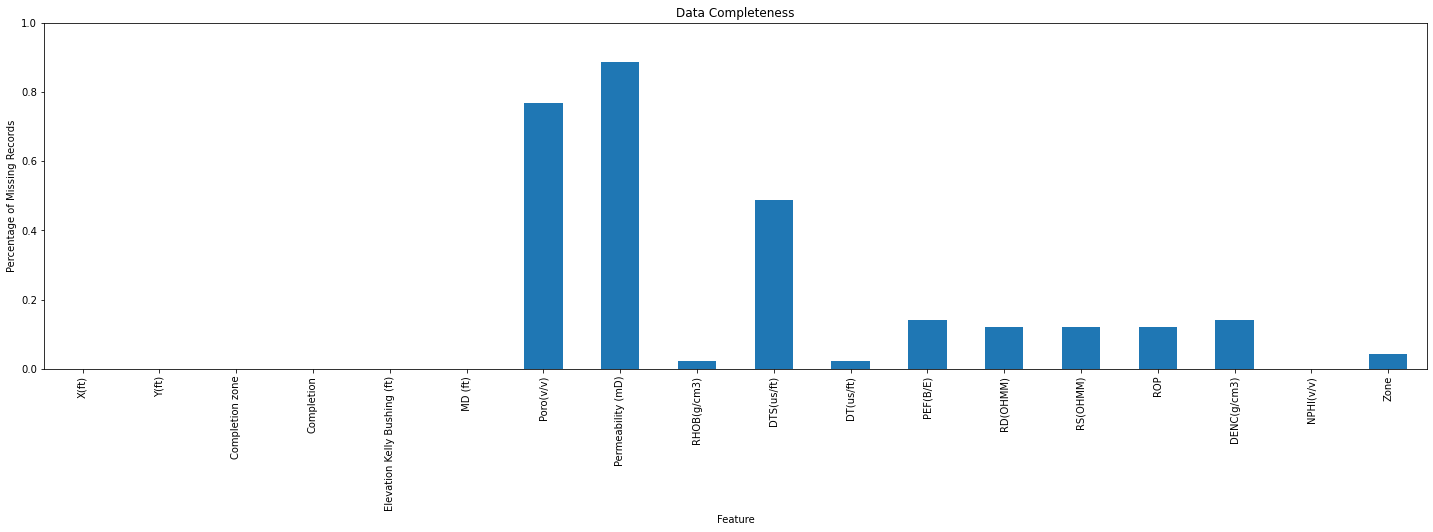

In [7]:
(wells_df.isnull().sum()/len(wells_df)).plot(kind = 'bar')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.ylim([0,1.0])
plt.show()

## FEATURE IMPUTATION  
- We first drop the features that are not insightful for our analysis

In [233]:
# DROP UNUSEFUL COLUMNS
df_imputed = wells_df.copy(deep=True)   # make a deep copy of the DataFrame
df_imputed.drop(['Elevation Kelly Bushing (ft)','Completion', 'DTS(us/ft)', 'DT(us/ft)', 'PEF(B/E)', 'RD(OHMM)', 'RS(OHMM)', 'ROP', 'DENC(g/cm3)', 'Zone'], axis=1, inplace=True)
df_imputed.head()

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),RHOB(g/cm3),NPHI(v/v)
Well_ID,,,,,,,,
Well_0,137106.82,83818.47,0,4597.471739,NaN,NaN,2.700700,0.000000
Well_0,137106.82,83818.47,0,4604.031739,0.087413,NaN,2.819380,0.121538
Well_0,137106.82,83818.47,0,4610.591739,NaN,NaN,2.798909,0.248546
Well_0,137106.82,83818.47,0,4617.151739,0.059590,NaN,2.575396,0.142681
Well_0,137106.82,83818.47,0,4623.711739,NaN,NaN,2.895991,0.353600


In [234]:
df_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),455.0,0.131140,0.062887,0.019566,0.072468,0.129662,0.185373,0.249241
Permeability (mD),221.0,10.497034,39.248645,0.000001,0.019500,0.094813,1.948104,352.697773
RHOB(g/cm3),1918.0,2.472862,0.207148,1.991035,2.326909,2.469486,2.578890,3.044163
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738


- **DENSITY IMPUTATION:**  Bulk density includes the matrix and any fluid saturated pore volume within. Therefore a K Nearest Neighbors is a good method for this feature

In [235]:
df_knn = df_imputed.copy(deep=True)   # make a deep copy of the DataFrame
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_knn.iloc[:,:] = knn_imputer.fit_transform(df_knn)

In [236]:
df_imputed['RHOB(g/cm3)'] = df_knn['RHOB(g/cm3)']
df_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),455.0,0.131140,0.062887,0.019566,0.072468,0.129662,0.185373,0.249241
Permeability (mD),221.0,10.497034,39.248645,0.000001,0.019500,0.094813,1.948104,352.697773
RHOB(g/cm3),1963.0,2.474359,0.205946,1.991035,2.329274,2.472083,2.580801,3.044163
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738


- **POROSITY IMPUTATION:** for porosity, we have some core measurements (hard data) and porosity from logs (NPHI). We wanted to decided to cross validate the core measurements with the porosity log. We initially tried a LINEAR REGRESSION  between NPHI and Poro(v/v). However, the fit was not very convincing. Then, we tried a multilinear regression with 2 features: NPHI  and RHOB

In [237]:
porosity_df = (wells_df[['Poro(v/v)', 'NPHI(v/v)', 'RHOB(g/cm3)', 'Completion zone']])
porosity_df.head()

,Poro(v/v),NPHI(v/v),RHOB(g/cm3),Completion zone
Well_ID,,,,
Well_0,NaN,0.000000,2.700700,0
Well_0,0.087413,0.121538,2.819380,0
Well_0,NaN,0.248546,2.798909,0
Well_0,0.059590,0.142681,2.575396,0
Well_0,NaN,0.353600,2.895991,0


In [238]:
porosity_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Poro(v/v),455.0,0.131140,0.062887,0.019566,0.072468,0.129662,0.185373,0.249241
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738
RHOB(g/cm3),1918.0,2.472862,0.207148,1.991035,2.326909,2.469486,2.578890,3.044163
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000


In [239]:
porosity2_df = porosity_df.dropna()
porosity2_df.head()

,Poro(v/v),NPHI(v/v),RHOB(g/cm3),Completion zone
Well_ID,,,,
Well_0,0.087413,0.121538,2.819380,0
Well_0,0.059590,0.142681,2.575396,0
Well_0,0.082269,0.226349,2.831982,0
Well_0,0.062989,0.188662,2.727031,0
Well_0,0.067931,0.317625,2.974074,0


In [240]:
porosity2_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Poro(v/v),455.0,0.131140,0.062887,0.019566,0.072468,0.129662,0.185373,0.249241
NPHI(v/v),455.0,0.203304,0.110743,0.000000,0.121647,0.188193,0.245365,0.786988
RHOB(g/cm3),455.0,2.475084,0.213178,2.021383,2.336362,2.468460,2.589938,3.041181
Completion zone,455.0,0.542857,0.498708,0.000000,0.000000,1.000000,1.000000,1.000000


- The wells have been comleted in two different intervals. Therefore, we decided to subset the core porosity measurmentes for each interval (upper and lower) to identify possible correlations

In [243]:
por_upper_df = porosity2_df[porosity2_df['Completion zone']==0]
por_upper_df.describe().T


,count,mean,std,min,25%,50%,75%,max
Poro(v/v),208.0,0.120982,0.062531,0.026224,0.066350,0.100764,0.181212,0.249241
NPHI(v/v),208.0,0.212739,0.113857,0.000000,0.120654,0.198926,0.280975,0.786988
RHOB(g/cm3),208.0,2.476278,0.251717,2.021383,2.274563,2.472102,2.609761,3.041181
Completion zone,208.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [244]:
por_lower_df = porosity2_df[porosity2_df['Completion zone']==1]
por_lower_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Poro(v/v),247.0,0.139693,0.062030,0.019566,0.079900,0.148503,0.192791,0.244583
NPHI(v/v),247.0,0.195359,0.107642,0.042470,0.122611,0.182560,0.217577,0.740866
RHOB(g/cm3),247.0,2.474079,0.174791,2.036921,2.360671,2.467156,2.580999,2.955648
Completion zone,247.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- **Linear Regression** we generated cross plots Neutron Porosity (NPHI) VS. Core Porosity for each intervl and perfromed linear regression in order to create a physics based model to impute the porosity data.  

In [246]:
# Fitting a line
x1 = por_upper_df['NPHI(v/v)']
y1 = por_upper_df['Poro(v/v)']
c1 = np.polyfit(x1,y1,1) # Calculate the polynomial fit
ycalc1 = np.polyval(c1,x1) # Using the polynomial, calculate values for array x


x2 = por_lower_df['NPHI(v/v)']
y2 = por_lower_df['Poro(v/v)']
c2 = np.polyfit(x2,y2,1) # Calculate the polynomial fit
ycalc2 = np.polyval(c2,x2) # Using the polynomial, calculate values for array x



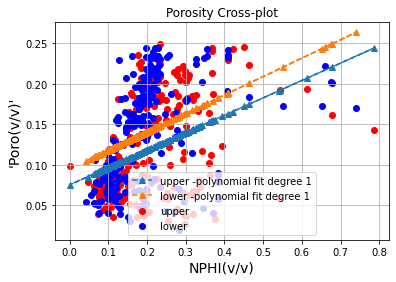

In [247]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.scatter(x1, y1, color='r', label='upper')
ax.scatter(x2, y2, color='b', label='lower')
#ax.plot(x1,y1,'o',label='values')
ax.plot(x1,ycalc1,'--^',label='upper -polynomial fit degree 1')
ax.plot(x2,ycalc2,'--^',label='lower -polynomial fit degree 1')
ax.legend(loc='best');

# set axis limits
# ax.set_xlim(0,10000)
# #ax.set_ylim(0,3000)
# set x-axis label
ax.set_xlabel('NPHI(v/v)',fontsize=14)
# set y-axis label
ax.set_ylabel("'Poro(v/v)'",color="black",fontsize=14)
ax.set_title('Porosity Cross-plot')
plt.grid()
plt.legend(loc=8)
# twin object for two different y-axis on the sample plot

#ax2=ax.twinx()
# make a plot with different y-axis using second axis object
#ax2.plot(df['Time (s)'], df['Ev(Lc)'], 'g', label='Ev')
#ax2.set_ylabel("Volumetric Strain [-]",color="green",fontsize=14)
#plt.legend(loc=9)

plt.show()
# save the plot as a file
# fig.savefig('He_porosity.png',dpi=300, facecolor='w', edgecolor='w',
#         orientation='portrait', format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         metadata=None)

In [ ]:
#MERGE WITH CUMULATIVE PRODUCTION
production_history_df = pd.read_csv('Well_Production.csv', index_col='Well_ID')
# production_history_df.head()
production_df = wells_df.merge(production_history_df, how='left', left_index=True, right_index=True)
production_df.head()

#### Summary Statistics

Summary statistics of one variable at a time. The describe command provides count, mean, minimum, maximum, and quartiles all in a compact data table. We use transpose() command to flip the table so that features are on the rows and the statistics are on the columns.

- However, this linear regression is affected by outliers and do not provide a good fit to model for our porosity imputation. However, the dispersion of the data suggest possible linear correlations. Thus, we decided to perform **MULTILNIEAR REGRESSION** to predict the porosity for each layer using the Neutron Porosity (NPHI) and density log (RHOB)

#### MULTILINEAR REGRESSION

In [248]:
# Select 2 predictor features here:
predictor_features = ['NPHI(v/v)','RHOB(g/cm3)']           # for the first demonstration run we will use porosity and brittleness
#

response_feature = 'Poro(v/v)'

pindex = np.argwhere(por_upper_df.columns.isin(predictor_features)).ravel()
print('Selected predictor features: \n0: ' + predictor_features[0] + ', index = ' + str(pindex[0]) + '.')
print('1: ' + predictor_features[1] + ', index = ' + str(pindex[1]) + '.')
rindex = np.argwhere(por_upper_df.columns.isin([response_feature])).ravel()
print('\nSelected response feature: \n' + response_feature + ', index = ' + str(rindex[0]) + '.')

#my_data_cut = my_data.iloc[0:500,:] 
X = por_upper_df[predictor_features]                # extract the 2 selected response features, 500 samples to a X array
y = por_upper_df[[response_feature]]    

Selected predictor features: 
0: NPHI(v/v), index = 1.
1: RHOB(g/cm3), index = 2.

Selected response feature: 
Poro(v/v), index = 0.


In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73073)
n_train = len(X_train)
n_test = len(X_test)
print('Number of training ' + str(n_train) + ', number of test ' + str(n_test))

Number of training 166, number of test 42


NPHI(v/v) Coef: 0.091, RHOB(g/cm3) Coef:  -0.191, Intercept:  0.573
Variance explained: 0.70


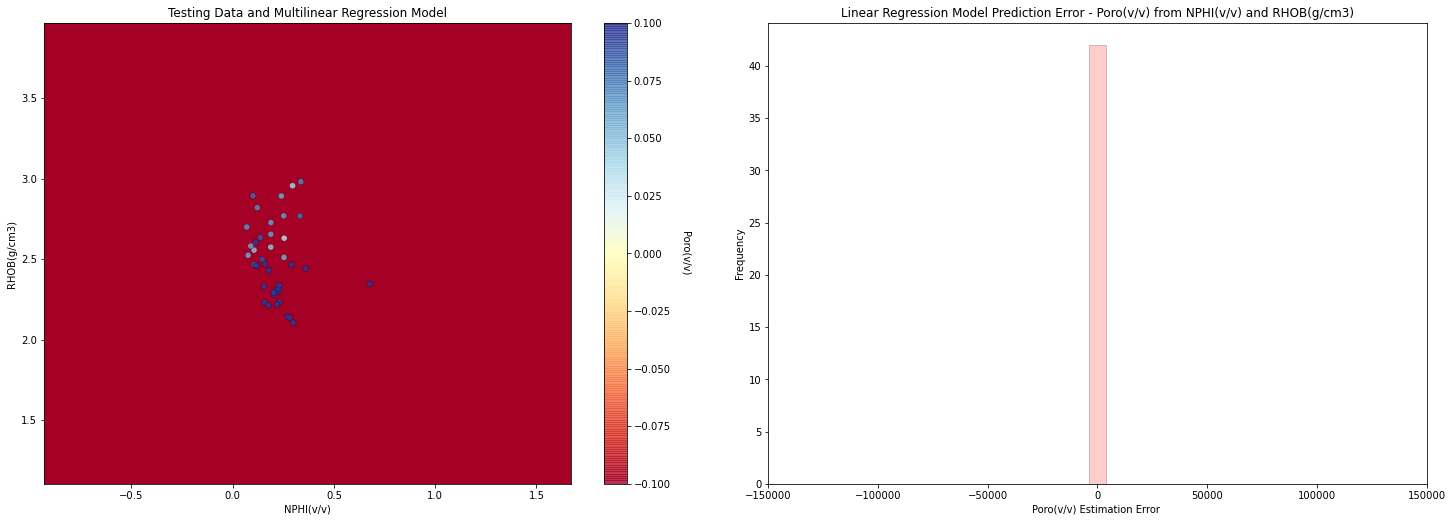

In [250]:
# Step 1. Instantiate the Model 
multilinear_reg = linear_model.LinearRegression()

# Step 2: Fit the Data on Training Data
multilinear_reg.fit(X_train.values.reshape(n_train,2), y_train[response_feature]) # fit model

# Print the model parameters
print(predictor_features[0] + ' Coef: ' + str(round(multilinear_reg.coef_[0],3)) + ', ' + predictor_features[1] + ' Coef: ', str(round(multilinear_reg.coef_[1],3)) + ', Intercept: ', str(round(multilinear_reg.intercept_,3))) 

# Plot model fit
plt.subplot(121)
plt = visualize_model(multilinear_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Testing Data and Multilinear Regression Model')

# Step 3: - Make predictions using the testing dataset
multilinear_y_pred = multilinear_reg.predict(X_test.values.reshape(n_test,2))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, multilinear_y_pred))

# Calculate the error at withheld testing samples
multilinear_y_res = multilinear_y_pred - y_test[response_feature].values

plt.subplot(122)
plt.hist(multilinear_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.6, wspace=0.1, hspace=0.2)
plt.show()


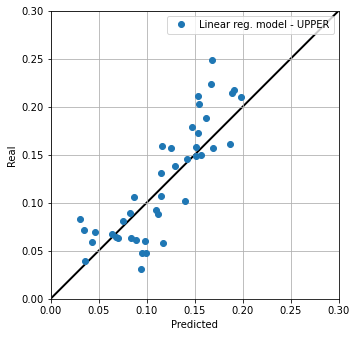

In [251]:
#Plot the model 
fig,ax = plt.subplots()
# make a plot
plt.plot(multilinear_y_pred, y_test, 'o', label="Linear reg. model - UPPER")
plt.arrow(0,0,0.3,0.3)
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.grid()
plt.xlabel("Predicted"); plt.ylabel("Real"); plt.legend();
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.3, top=1, wspace=0.2, hspace=0.3)
ax.set_aspect('equal', adjustable='box')
plt.show()


#### MultiLinear Regression for LOWER  completion zone

In [252]:
# Select 2 predictor features here:
predictor_features = ['NPHI(v/v)','RHOB(g/cm3)']           # for the first demonstration run we will use porosity and brittleness
#

response_feature = 'Poro(v/v)'

pindex = np.argwhere(por_upper_df.columns.isin(predictor_features)).ravel()
print('Selected predictor features: \n0: ' + predictor_features[0] + ', index = ' + str(pindex[0]) + '.')
print('1: ' + predictor_features[1] + ', index = ' + str(pindex[1]) + '.')
rindex = np.argwhere(por_upper_df.columns.isin([response_feature])).ravel()
print('\nSelected response feature: \n' + response_feature + ', index = ' + str(rindex[0]) + '.')

#my_data_cut = my_data.iloc[0:500,:] 
X = por_lower_df[predictor_features]                # extract the 2 selected response features, 500 samples to a X array
y = por_lower_df[[response_feature]]    

Selected predictor features: 
0: NPHI(v/v), index = 1.
1: RHOB(g/cm3), index = 2.

Selected response feature: 
Poro(v/v), index = 0.


In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73073)
n_train = len(X_train)
n_test = len(X_test)
print('Number of training ' + str(n_train) + ', number of test ' + str(n_test))

Number of training 197, number of test 50


NPHI(v/v) Coef: 0.067, RHOB(g/cm3) Coef:  -0.278, Intercept:  0.816
Variance explained: 0.75


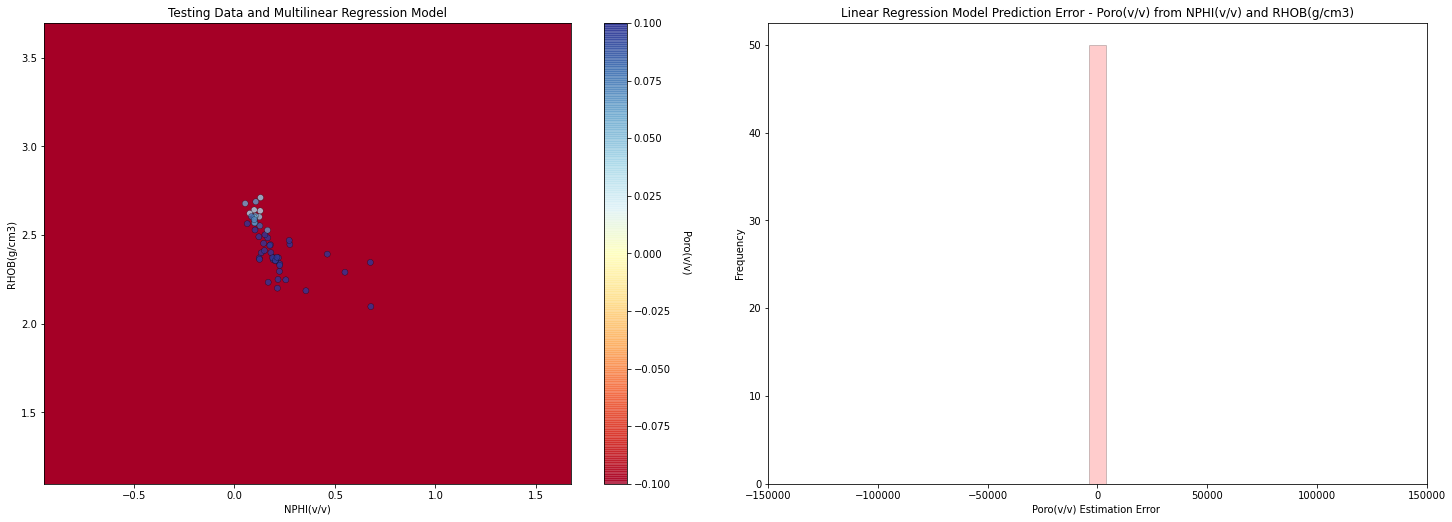

In [254]:
# Step 1. Instantiate the Model 
multilinear_reg = linear_model.LinearRegression()

# Step 2: Fit the Data on Training Data
multilinear_reg.fit(X_train.values.reshape(n_train,2), y_train[response_feature]) # fit model

# Print the model parameters
print(predictor_features[0] + ' Coef: ' + str(round(multilinear_reg.coef_[0],3)) + ', ' + predictor_features[1] + ' Coef: ', str(round(multilinear_reg.coef_[1],3)) + ', Intercept: ', str(round(multilinear_reg.intercept_,3))) 

# Plot model fit
plt.subplot(121)
plt = visualize_model(multilinear_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Testing Data and Multilinear Regression Model')

# Step 3: - Make predictions using the testing dataset
multilinear_y_pred = multilinear_reg.predict(X_test.values.reshape(n_test,2))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, multilinear_y_pred))

# Calculate the error at withheld testing samples
multilinear_y_res = multilinear_y_pred - y_test[response_feature].values

plt.subplot(122)
plt.hist(multilinear_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.6, wspace=0.1, hspace=0.2)
plt.show()

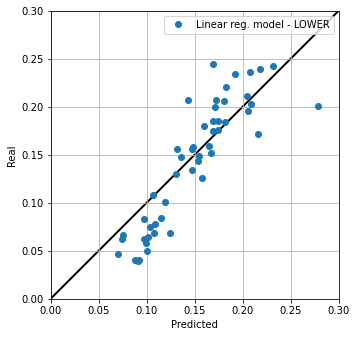

In [255]:
#Plot the model 
fig,ax = plt.subplots()
#plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue', label="Training")
plt.plot(multilinear_y_pred, y_test, 'o', label="Linear reg. model - LOWER")
plt.arrow(0,0,0.3,0.3)
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.grid()
plt.xlabel("Predicted"); plt.ylabel("Real"); plt.legend();
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.3, top=1, wspace=0.2, hspace=0.3)
ax.set_aspect('equal', adjustable='box')
plt.show()

In [256]:
df_por = df_imputed.copy(deep=True)   # make a deep copy of the DataFrame
len(df_por)

1963

- Now that we have the multilinear regression  odels for each layer, we can impute the porosity

In [257]:

df_por = df_imputed.copy(deep=True)   # make a deep copy of the DataFrame

for i in range(len(df_por)):
    if (math.isnan(df_por['Poro(v/v)'][i]) and df_por['Completion zone'][i]==0) :
        #print(i,df_por['Completion zone'][i], math.isnan(df_por['Poro(v/v)'][i]))
        df_por['Poro(v/v)'][i]= (0.091*df_por['NPHI(v/v)'][i])-(0.191*df_por['RHOB(g/cm3)'][i])+0.573
    elif (math.isnan(df_por['Poro(v/v)'][i]) and df_por['Completion zone'][i]==1):
        #print(i,df_por['Completion zone'][i], math.isnan(df_por['Poro(v/v)'][i]))
        df_por['Poro(v/v)'][i] = (0.067*df_por['NPHI(v/v)'][i])-(0.278*df_por['RHOB(g/cm3)'][i])+0.816
df_por.head(n=5)

C:\Users\monic\AppData\Local\Temp/ipykernel_40980/4074718225.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_por['Poro(v/v)'][i]= (0.091*df_por['NPHI(v/v)'][i])-(0.191*df_por['RHOB(g/cm3)'][i])+0.573
C:\Users\monic\AppData\Local\Temp/ipykernel_40980/4074718225.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_por['Poro(v/v)'][i] = (0.067*df_por['NPHI(v/v)'][i])-(0.278*df_por['RHOB(g/cm3)'][i])+0.816


,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),RHOB(g/cm3),NPHI(v/v)
Well_ID,,,,,,,,
Well_0,137106.82,83818.47,0,4597.471739,0.057166,NaN,2.700700,0.000000
Well_0,137106.82,83818.47,0,4604.031739,0.087413,NaN,2.819380,0.121538
Well_0,137106.82,83818.47,0,4610.591739,0.061026,NaN,2.798909,0.248546
Well_0,137106.82,83818.47,0,4617.151739,0.059590,NaN,2.575396,0.142681
Well_0,137106.82,83818.47,0,4623.711739,0.052043,NaN,2.895991,0.353600


In [258]:
# prevent negative values with truncation
num = df_por._get_numeric_data()                    # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0
df_imputed['Poro(v/v)'] = df_por['Poro(v/v)']
df_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),1963.0,0.132445,0.056066,0.000000,0.093060,0.129367,0.173578,0.323677
Permeability (mD),221.0,10.497034,39.248645,0.000001,0.019500,0.094813,1.948104,352.697773
RHOB(g/cm3),1963.0,2.474359,0.205946,1.991035,2.329274,2.472083,2.580801,3.044163
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738


- **PERMEABILITY IMPUTATION** Same as core porosity. We only have permeability measurements where cores were acquired. Then we decided to use Carman Kozeny model to calcularte the permeability using our porosity values. Where κ is the permeability and ϕ is the porosity.   
- **The workflow for the permeabilty imputation was designed by Dr. John Foster**

$\kappa \sim \phi^3/(1−\phi)^2$
 


C:\Users\monic\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


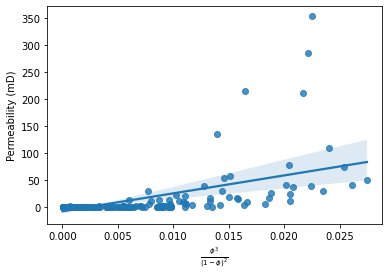

In [259]:
# Pipeline designed by Dr. John Foster 
df_perm = df_imputed.copy(deep=True)   # make a deep copy of the DataFrame
# print(len(missing_perms))
missing_perms = df_perm['Permeability (mD)'].isnull()
phi = df_perm.loc[~missing_perms, 'Poro(v/v)'].to_numpy()
fig, ax = plt.subplots()
sns.regplot(phi ** 3 / (1 - phi) ** 2, 
            wells_df.loc[~missing_perms, 'Permeability (mD)'], ax=ax);
ax.set_xlabel(r'$\frac{\phi^3}{(1 - \phi)^2}$');


- First we find the slope and intercept of the blue line above.

In [260]:
fphi = lambda phi, m, kappa0: m * phi ** 3 / (1 - phi) ** 2 + kappa0
popt, _ = curve_fit(fphi, phi, df_perm.loc[~missing_perms, 'Permeability (mD)'])

# fphi = lambda phi, m, kappa0: m * phi ** 3 / (1 - phi) ** 2 + kappa0
# popt, _ = curve_fit(fphi, phi, wells_df.loc[~missing_perms, 'Permeability (mD)'])

- Now we'll use the model to create a feature we'll call ``KC permeability, mD'``.

In [261]:
df_perm['KC permeability (mD)'] = fphi(df_perm['Poro(v/v)'], 
                                      popt[0], popt[1])

In [262]:
df_perm.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),1963.0,0.132445,0.056066,0.000000,0.093060,0.129367,0.173578,0.323677
Permeability (mD),221.0,10.497034,39.248645,0.000001,0.019500,0.094813,1.948104,352.697773
RHOB(g/cm3),1963.0,2.474359,0.205946,1.991035,2.329274,2.472083,2.580801,3.044163
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738
KC permeability (mD),1963.0,10.937444,22.481392,-7.243402,-4.001010,2.208734,18.096608,238.090327


- Using the data show above, we'll build a model to impute the missing permeabilities. Again, using GridSearchCV to hyperparameter tune, we have

In [263]:
scalers = [MaxAbsScaler(), MinMaxScaler(), StandardScaler(), RobustScaler()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('poly', PolynomialFeatures()),
    ('reg', LinearRegression())
])

params = {
    'scaler': scalers,
    'poly__degree': [2, 3, 4],
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7],
}

gcv = GridSearchCV(pipe, params, cv=KFold(random_state=5, shuffle=True))
gcv.fit(df_perm[~missing_perms].drop('Permeability (mD)', axis=1), 
        df_perm.loc[~missing_perms, 'Permeability (mD)'])
gcv.best_params_

{'pca__n_components': 1, 'poly__degree': 2, 'scaler': RobustScaler()}

- With these parameters, we can predict the missing permeabilities.

In [264]:
df_perm.loc[missing_perms, 'Permeability (mD)'] = \
    gcv.predict(df_perm[missing_perms].drop('Permeability (mD)', axis=1))

In [265]:
# prevent negative values with truncation
num = df_perm._get_numeric_data()                    # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0
df_perm.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),1963.0,0.132445,0.056066,0.000000,0.093060,0.129367,0.173578,0.323677
Permeability (mD),1963.0,12.417411,33.259635,0.000000,0.000000,0.063276,8.568973,673.495316
RHOB(g/cm3),1963.0,2.474359,0.205946,1.991035,2.329274,2.472083,2.580801,3.044163
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738
KC permeability (mD),1963.0,12.824067,21.218079,0.000000,0.000000,2.208734,18.096608,238.090327


- Visualizing the results of the prediction against the given data, this model appears to perform well.

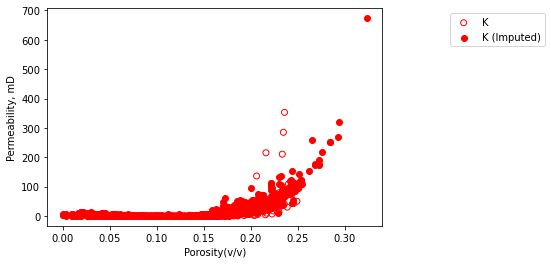

In [266]:
fig, ax = plt.subplots()
ax.scatter(df_perm[~missing_perms]['Poro(v/v)'], df_perm[~missing_perms]['Permeability (mD)'], 
           color='r', facecolors='none', label='K')
ax.scatter(df_perm[missing_perms]['Poro(v/v)'], 
           df_perm[missing_perms]['Permeability (mD)'], 
           color='r', label='K (Imputed)')
ax.set_xlabel('Porosity(v/v)')
ax.set_ylabel('Permeability, mD')
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right', ncol=1);


In [267]:
#The 'KC permeability, mD' is redundant now, so we'll drop it from the dataframe.

df_perm.drop('KC permeability (mD)', axis=1, inplace=True)
df_imputed['Permeability (mD)'] = df_perm['Permeability (mD)'] 

In [268]:
df_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),1963.0,124890.354575,9775.363008,109560.260000,115987.290000,124094.800000,134042.860000,142095.820000
Y(ft),1963.0,87551.832639,3210.182762,81747.120000,84476.470000,88549.740000,89987.000000,93691.550000
Completion zone,1963.0,0.590932,0.491787,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),1963.0,4673.224657,165.718326,4228.005683,4546.547857,4666.802978,4796.413228,5096.702794
Poro(v/v),1963.0,0.132445,0.056066,0.000000,0.093060,0.129367,0.173578,0.323677
Permeability (mD),1963.0,12.417411,33.259635,0.000000,0.000000,0.063276,8.568973,673.495316
RHOB(g/cm3),1963.0,2.474359,0.205946,1.991035,2.329274,2.472083,2.580801,3.044163
NPHI(v/v),1963.0,0.200208,0.107532,0.000000,0.122878,0.186431,0.244933,1.021738


## UPSCALING: from Well-log scale to Well scale  
- We have multiple entries per well. Now we will upscale to average properties for the entire well

In [269]:
df_imputed['Zone']=well_logs_df['Zone']
df_imputed.head(n=10)

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),RHOB(g/cm3),NPHI(v/v),Zone
Well_ID,,,,,,,,,
Well_0,137106.82,83818.47,0,4597.471739,0.057166,7.888303,2.700700,0.000000,Upper
Well_0,137106.82,83818.47,0,4604.031739,0.087413,4.408944,2.819380,0.121538,Upper
Well_0,137106.82,83818.47,0,4610.591739,0.061026,1.353763,2.798909,0.248546,Upper
Well_0,137106.82,83818.47,0,4617.151739,0.059590,0.000000,2.575396,0.142681,Upper
Well_0,137106.82,83818.47,0,4623.711739,0.052043,1.461211,2.895991,0.353600,Upper
Well_0,137106.82,83818.47,0,4630.271739,0.082269,1.532611,2.831982,0.226349,Upper
Well_0,137106.82,83818.47,0,4636.831739,0.055201,5.250441,2.774357,0.133007,Upper
Well_0,137106.82,83818.47,0,4643.391739,0.062989,1.049195,2.727031,0.188662,Upper
Well_0,137106.82,83818.47,0,4649.951739,0.030784,11.701884,2.926972,0.185004,Upper


In [270]:
df_imputed['Zone']=df_imputed['Zone'].replace(np.nan,0)
df_imputed['Zone'].replace(['Upper','Lower'], [0,1], inplace=True)
df_imputed['mark']=df_imputed['Zone']-df_imputed['Completion zone']
df_mean = df_imputed[df_imputed['mark']==0].copy(deep=True)   # make a deep copy of the DataFrame
df_mean.drop(['RHOB(g/cm3)','NPHI(v/v)' ,'Zone', 'mark'], axis=1, inplace=True)
well_summary_df = df_mean.groupby(df_mean.index).mean()

In [271]:
well_summary_df.head()

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD)
Well_ID,,,,,,
Well_0,137106.82,83818.47,0.0,4659.791739,0.074403,3.098397
Well_1,132460.98,85832.77,0.0,4868.900545,0.126777,13.832289
Well_10,134042.86,82411.27,0.0,4749.294657,0.125236,2.528347
Well_11,115725.49,86866.60,0.0,4628.309023,0.085998,0.635944
Well_12,133136.98,93691.55,1.0,4821.390995,0.130572,2.760318


### ACOUSTIC IMPEDANCE  
- We have two instnces of acoustic impedance taken with a difference of nearly 10 years.
- Frist, we are going to map the **ACOUSTIC IMPEDANCE**  for this 2 different event and compute the difference between them.  
- The acoustic impedance is the ratio of the density and the wav velocity. Therefore, it is a function of the lithology, pore volume and fluid saturation. 
- We will use the difference between AI to get an idea of the depletion of the reservoir
- We use ``NearestNDInterpolator`` to extract the value of AI for all the wells in the reservoir

In [404]:
from scipy.interpolate import NearestNDInterpolator


#Separete dataset in UPPER and Lower
df = pd.read_csv('Well_Head_and_Completion.csv', index_col='Well_ID')
df_Upper=df[df["Completion"] =="Upper"]
df_Lower=df[df["Completion"] =="Lower"]

df_AI = pd.read_csv('AI.csv')
df_AI.describe()

#Inpute the AI for each well location from the AI MAP 2020
x = df_AI['X(ft)']
y = df_AI['Y(ft)']
AIu= df_AI['AI_upper(2021-12-20)']
X= np.linspace(min(x), max(x))
Y= np.linspace(min(y), max(y))
X, Y= np.meshgrid(X, Y)  # 2D grid for interpolation
interp_upper= NearestNDInterpolator(list(zip(x, y)), AIu)
Xu=df_Upper['X(ft)']
Yu=df_Upper['Y(ft)']
AIu = interp_upper(Xu, Yu)


AIl= df_AI['AI_lower(2021-12-20)']
interp = NearestNDInterpolator(list(zip(x, y)), AIl)
Xl=df_Lower['X(ft)']
Yl=df_Lower['Y(ft)']
AIl = interp(Xl, Yl)
Xln=[125500, 134000, 131000]
Yln=[88000, 88000, 87500]
AIln=interp(Xln, Yln)

df_Upper["AI"]=AIu
df_Lower["AI"]=AIl

wells_df1 = pd.concat([df_Lower, df_Upper])
wells_df1 =wells_df1.sort_values(by='Well_ID')

C:\Users\monic\AppData\Local\Temp/ipykernel_40980/1140994684.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Upper["AI"]=AIu
C:\Users\monic\AppData\Local\Temp/ipykernel_40980/1140994684.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Lower["AI"]=AIl


In [360]:
AIln

array([6627.10689892, 6591.07568549, 6249.97858068])

In [361]:
wells_df1.head()

,X(ft),Y(ft),Completion,Elevation Kelly Bushing (ft),WOPR (bpd),Np (bls),AI
Well_ID,,,,,,,
Well_0,137106.82,83818.47,Upper,193.32,8.809168,14473.503510,6527.288321
Well_1,132460.98,85832.77,Upper,187.15,38.675641,30591.819370,6523.526063
Well_10,134042.86,82411.27,Upper,184.33,46.363101,48077.967090,6473.198759
Well_11,115725.49,86866.60,Upper,192.03,0.000000,0.000000,6430.629923
Well_12,133136.98,93691.55,Lower,170.35,0.664632,1759.350823,6362.714848


In [279]:
wells_df1.drop(['X(ft)', 'Y(ft)', 'Completion', 'Elevation Kelly Bushing (ft)'], axis=1, inplace=True)
wells_df1.head()

,WOPR (bpd),Np (bls),AI
Well_ID,,,
Well_0,8.809168,14473.503510,6527.288321
Well_1,38.675641,30591.819370,6523.526063
Well_10,46.363101,48077.967090,6473.198759
Well_11,0.000000,0.000000,6430.629923
Well_12,0.664632,1759.350823,6362.714848


In [280]:
wells_df2 =  wells_df1.copy(deep=True)   # make a deep copy of the DataFrame
# wells_df2.head()
wells_df2 = well_summary_df.merge(wells_df2, how='left', 
                              left_index=True, 
                              right_index=True)
wells_df2.head()

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),WOPR (bpd),Np (bls),AI
Well_ID,,,,,,,,,
Well_0,137106.82,83818.47,0.0,4659.791739,0.074403,3.098397,8.809168,14473.503510,6527.288321
Well_1,132460.98,85832.77,0.0,4868.900545,0.126777,13.832289,38.675641,30591.819370,6523.526063
Well_10,134042.86,82411.27,0.0,4749.294657,0.125236,2.528347,46.363101,48077.967090,6473.198759
Well_11,115725.49,86866.60,0.0,4628.309023,0.085998,0.635944,0.000000,0.000000,6430.629923
Well_12,133136.98,93691.55,1.0,4821.390995,0.130572,2.760318,0.664632,1759.350823,6362.714848


In [281]:
wells_df2.to_csv('Wells_feature_ranking.csv') 

In [282]:
wells_df3 = pd.read_csv('Wells_feature_ranking.csv', usecols=['Well_ID','X(ft)', 'Y(ft)', 'Completion zone', ' MD (ft)', 'Poro(v/v)', 'Permeability (mD)', 'AI', 'Np (bls)'], index_col='Well_ID')
wells_df3 = wells_df3.reindex(columns=['X(ft)', 'Y(ft)', 'Completion zone', ' MD (ft)', 'Poro(v/v)', 'Permeability (mD)', 'AI', 'Np (bls)'])
wells_df3.head()

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),AI,Np (bls)
Well_ID,,,,,,,,
Well_0,137106.82,83818.47,0.0,4659.791739,0.074403,3.098397,6527.288321,14473.503510
Well_1,132460.98,85832.77,0.0,4868.900545,0.126777,13.832289,6523.526063,30591.819370
Well_10,134042.86,82411.27,0.0,4749.294657,0.125236,2.528347,6473.198759,48077.967090
Well_11,115725.49,86866.60,0.0,4628.309023,0.085998,0.635944,6430.629923,0.000000
Well_12,133136.98,93691.55,1.0,4821.390995,0.130572,2.760318,6362.714848,1759.350823


### FEATURE RANKING  
- the functions used for feature ranking were coded by Dr. Michael Pyrcz

In [283]:
def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

- We will compute the ``Partial Correlation`` and ``Semipartial correlation`` coefficients to map which features are more important for our prediction

In [284]:
partial_correlation = partial_corr(wells_df3.iloc[:,:8]) # calculate the partial correlation coefficients
partial_correlation = partial_correlation[:,7][:7] # extract a single row and remove production with itself
semipartial_correlation = semipartial_corr(wells_df3.iloc[:,:8]) # calculate the semi-partial correlation coefficients
semipartial_correlation = semipartial_correlation[:,7][:7] # extract a single row and remove production with itself

C:\Users\monic\AppData\Local\Temp/ipykernel_40980/2152434617.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  P_corr = np.zeros((p, p), dtype=np.float)
C:\Users\monic\AppData\Local\Temp/ipykernel_40980/2152434617.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.ones(p, dtype=np.bool)
C:\Users\monic\AppData\Local\Temp/ipykernel

<function matplotlib.pyplot.show(close=None, block=None)>

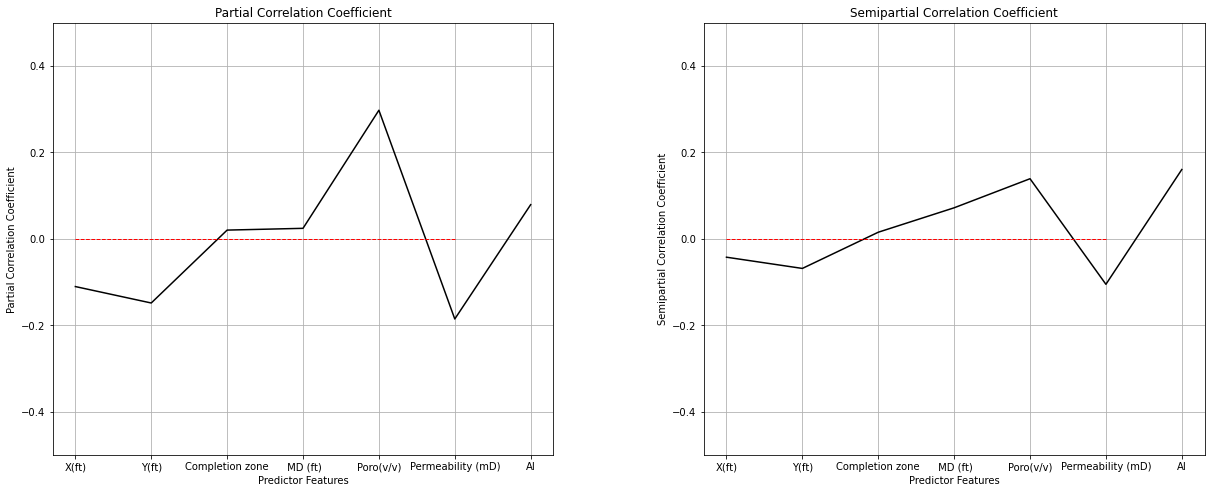

In [285]:
features = wells_df3.columns.values[:][:7]
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(features,partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-0.5,0.5)
plt.grid(True)

plt.subplot(122)
plt.plot(features,semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-0.5,0.5)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=1.2, wspace=0.3, hspace=0.2)
plt.show

- from the plots we can conclude that POROSITY  and ACOUSTIC IMPEDANCE have the most impactful effect on our response feature. it can be argued that PERMEABILITY could be used as a predictor feature. However, the physics-based model used to estimate permeability relies on the imputed porosity values. Therefore, this could add colinerity to our models.

## VISUALIZATION  
- In this section, we present the AI maps overimposed by bubble map showing the cumulative production per well.

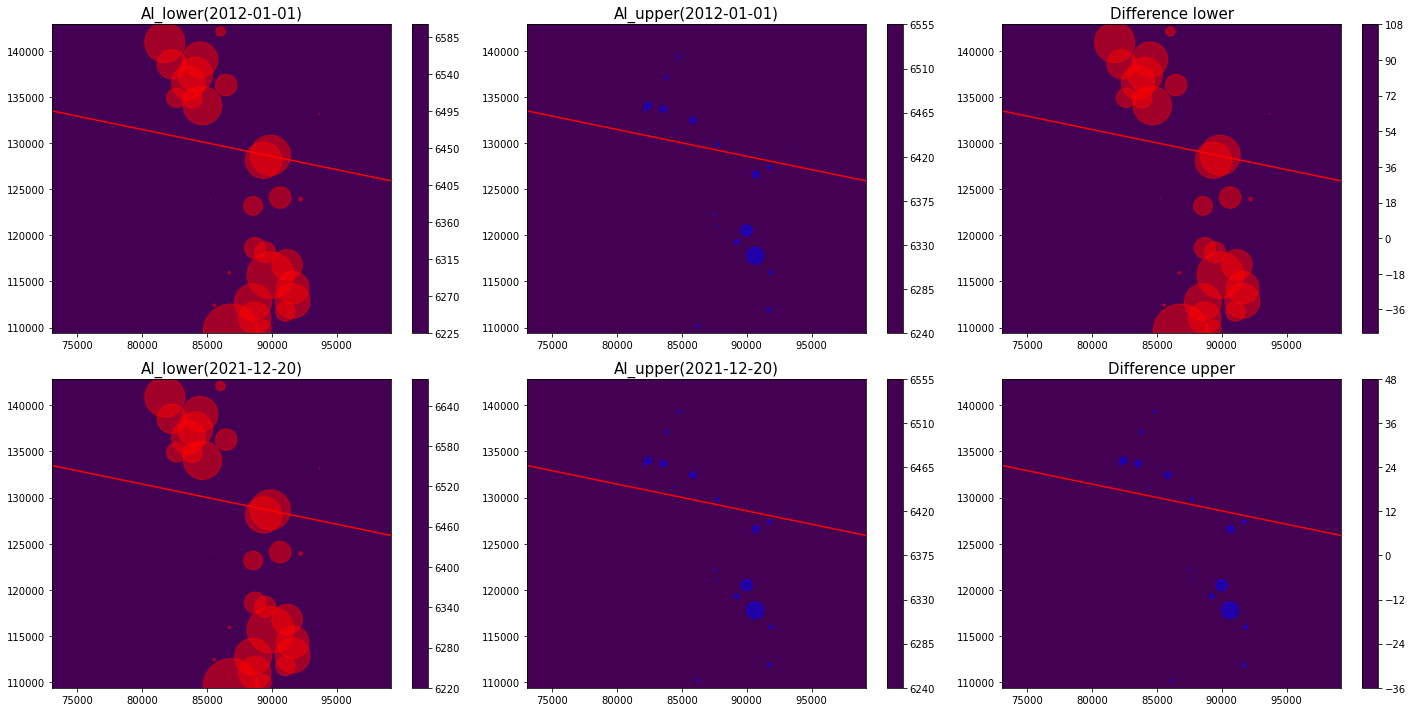

In [286]:
df_AI = pd.read_csv('AI.csv')
df_AI['Difference lower'] = df_AI['AI_lower(2021-12-20)'] - df_AI['AI_lower(2012-01-01)']
df_AI['Difference upper'] = df_AI['AI_upper(2021-12-20)'] - df_AI['AI_upper(2012-01-01)']

df_AI
     
location_AI = df_AI[['X(ft)', 'Y(ft)']]

df_head_completion = pd.read_csv('Well_Production.csv')
location_well = df_head_completion[['WOPR (bpd)','X(ft)','Y(ft)']] 

plt.figure(figsize=(20, 10))
for i, col in enumerate(['AI_lower(2012-01-01)', 'AI_upper(2012-01-01)','Difference lower',
                             'AI_lower(2021-12-20)', 'AI_upper(2021-12-20)','Difference upper']):
    ax = plt.subplot(2, 3, i+1)
    ai = df_AI[col]

    # Plot heatmap
    plt.title(col, fontsize=15)
    y = location_AI['X(ft)']
    x = location_AI['Y(ft)']
    xi = np.linspace(x.min(), x.max(), 1000)
    yi = np.linspace(y.min(), y.max(), 1000)
    zi = griddata((x.to_numpy(), y.to_numpy()), ai, (xi[None, :],yi[:, None]), method='cubic')

    cs = plt.contourf(xi, yi, zi, 25)
    for i in cs.collections:
        i.set_label('nolegend')
    cbar = plt.colorbar()

    # Plot the location of the wells
    upper = df_head_completion['Completion'].isin(['Upper'])
    location_upper = location_well.loc[upper]
    location_lower = location_well.loc[~upper]
    ax = plt.gca()
    if 'upper' in col:
        ax.scatter(location_upper['Y(ft)'], location_upper['X(ft)'], location_upper['WOPR (bpd)'],color='b', marker='o', alpha=0.5)
    else:
        ax.scatter(location_lower['Y(ft)'], location_lower['X(ft)'], location_lower['WOPR (bpd)'], color='r', marker='o', alpha=0.5)
    plt.clim(0,7e6)    
    Y1=np.linspace(x.min(), x.max(), 20000)
    X1=-0.29*Y1+154670
    ax.plot(Y1,X1,color = 'r')


plt.tight_layout()
plt.show()


## MACHINE LEARNING MODEL -  DECISION TREE - Oil Rate

In [296]:
# FUNCTIONS WRITTEN BY DR. MICHAEL PYRCZ
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0,cmap = plt.cm.bwr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
# def visualize_tree(tree,xfeature,xmin,xmax,yfeature,ymin,ymax,response,zmin,zmax,title,):# plots the data points and the decision tree prediction 
#     n_classes = 10
#     xstep = (xmax - xmin)/float(100); ystep = (ymax-ymin)/float(100)
#     resp_min = round(min(response)); resp_max = round(max(response));
#     xx, yy = np.meshgrid(np.arange(xmin, xmax, xstep),
#                      np.arange(ymin, ymax, ystep))
#     Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#     cs = plt.contourf(xx, yy, Z, cmap=plt.cm.inferno,vmin=zmin, vmax=zmax, levels = 100)
#     im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=plt.cm.inferno, norm=None, vmin=zmin, vmax=zmax, alpha=0.8, linewidths=0.3, edgecolors="white")
#     plt.title(title)
#     plt.xlabel(xfeature.name)
#     plt.ylabel(yfeature.name)
#     plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
#     cbar = plt.colorbar(im, orientation = 'vertical')
#     cbar.set_label(response.name, rotation=270, labelpad=20)
    
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    cmap = plt.cm.inferno
    xplot_step = (x_max - x_min)/300.0; yplot_step = (y_max - y_min)/300.0 # resolution of the model visualization
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step), # set up the mesh
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])      # predict with our trained model over the mesh
    Z = Z.reshape(xx.shape)
    plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="white")
    im = plt.imshow(Z,interpolation = None,aspect = "auto",extent = [x_min,x_max,y_min,y_max], vmin = z_min, vmax = z_max,cmap = cmap)
    plt.title(title)                                       # add the labels
    plt.xlabel(xfeature.name); plt.ylabel(yfeature.name)
    plt.xlim([x_min,x_max]); plt.ylim([y_min,y_max])
    cbar = plt.colorbar(im, orientation = 'vertical')      # add the color bar
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return Z
    
def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (bls)'); plt.ylabel('Estimated Production (bls)')
    plt.xlim(0,3100); plt.ylim(0,3100)
    plt.arrow(0,0,3100,3100,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    #cor = math.sqrt(metrics.r2_score(response,predict_train))
    cor = (metrics.r2_score(response,predict_train))**0.5
    print('Mean Squared Error on Testing = ', round(MSE,2),', Correlation Coefficient = ', round(cor,2))

def tree_to_code(tree, feature_names):                    # code from StackOverFlow by paulkernfeld
    tree_ = tree.tree_                                    # convert tree object to portable code to use anywhere
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}elif {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1) 
    
def get_lineage(tree, feature_names):                     # code from StackOverFlow by Zelanzny7
    left      = tree.tree_.children_left                  # track the decision path for any set of inputs
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    # get ids of child nodes
    idx = np.argwhere(left == -1)[:,0]     
    def recurse(left, right, child, lineage=None):          
        if lineage is None:
            lineage = [child]
        if child in left:
            parent = np.where(left == child)[0].item()
            split = 'l'
        else:
            parent = np.where(right == child)[0].item()
            split = 'r'
        lineage.append((parent, split, threshold[parent], features[parent]))
        if parent == 0:
            lineage.reverse()
            return lineage
        else:
            return recurse(left, right, parent, lineage)
    for child in idx:
        for node in recurse(left, right, child):
            print(node) 

In [297]:
wells_df4 = pd.read_csv('Wells_feature_ranking.csv', usecols=['Well_ID','X(ft)', 'Y(ft)', 'Completion zone', ' MD (ft)', 'Poro(v/v)', 'Permeability (mD)', 'AI', 'WOPR (bpd)'], index_col='Well_ID')
wells_df4 = wells_df4.reindex(columns=['X(ft)', 'Y(ft)', 'Completion zone', ' MD (ft)', 'Poro(v/v)', 'Permeability (mD)', 'AI', 'WOPR (bpd)'])
wells_df4.head()

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),AI,WOPR (bpd)
Well_ID,,,,,,,,
Well_0,137106.82,83818.47,0.0,4659.791739,0.074403,3.098397,6527.288321,8.809168
Well_1,132460.98,85832.77,0.0,4868.900545,0.126777,13.832289,6523.526063,38.675641
Well_10,134042.86,82411.27,0.0,4749.294657,0.125236,2.528347,6473.198759,46.363101
Well_11,115725.49,86866.60,0.0,4628.309023,0.085998,0.635944,6430.629923,0.000000
Well_12,133136.98,93691.55,1.0,4821.390995,0.130572,2.760318,6362.714848,0.664632


In [298]:
wells_df4.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),50.0,124960.021054,9922.015780,109560.260000,115954.590000,124027.505000,133954.012500,142095.820000
Y(ft),50.0,87617.655277,3297.936805,81792.973846,84687.942500,87780.815000,90481.025000,93691.550000
Completion zone,50.0,0.597692,0.493235,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),50.0,4684.640791,152.593498,4293.605683,4578.519247,4680.457700,4793.418005,4978.818183
Poro(v/v),50.0,0.134331,0.035873,0.074403,0.108302,0.133547,0.154945,0.221956
Permeability (mD),50.0,14.957861,20.271745,0.000000,2.615153,7.079680,17.683856,89.126393
AI,50.0,6552.812214,79.439447,6362.714848,6495.933803,6545.065779,6622.551235,6677.045989
WOPR (bpd),50.0,514.362284,686.271526,0.000000,8.873609,194.174395,1007.989810,3060.205978


- Here we select the predictor features and response feature

In [299]:
# Select 2 predictor features here:
predictor_features = ['Poro(v/v)','AI']           # for the first demonstration run we will use porosity and brittleness
response_feature = 'WOPR (bpd)'
# msk = np.random.rand(len(df)) < 0.8 #Select at random 80% of the data for training

pindex = np.argwhere(wells_df4.columns.isin(predictor_features)).ravel()
print('Selected predictor features: \n0: ' + predictor_features[0] + ', index = ' + str(pindex[0]) + '.')
print('1: ' + predictor_features[1] + ', index = ' + str(pindex[1]) + '.')
rindex = np.argwhere(wells_df4.columns.isin([response_feature])).ravel()
print('\nSelected response feature: \n' + response_feature + ', index = ' + str(rindex[0]) + '.')

#my_data_cut = my_data.iloc[0:500,:] 
X = wells_df4[predictor_features]                # extract the 2 selected response features, 500 samples to a X array
y = wells_df4[[response_feature]]    

Selected predictor features: 
0: Poro(v/v), index = 4.
1: AI, index = 6.

Selected response feature: 
WOPR (bpd), index = 7.


- We used a 70/30 training/test split

In [300]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=73073)
n_train = len(X_train)
n_test = len(X_test)
print('Number of training ' + str(n_train) + ', number of test ' + str(n_test))

X_all = wells_df4[predictor_features]; y_all =  wells_df4[[response_feature]]   # training and testing together


Number of training 35, number of test 15


- For better viasualization, we extracted the min and max values for our predictors and response features

In [301]:
WOPRmin = 0.0; WOPRmax = 3100
pormin = 0.0; pormax = 0.3
AImin = 6000 ; AImax = 7000

- Let's initialize and train the model 

C:\Users\monic\AppData\Local\Temp/ipykernel_40980/734566587.py:53: RuntimeWarning: invalid value encountered in double_scalars
  cor = (metrics.r2_score(response,predict_train))**0.5


Mean Squared Error on Testing =  946094.53 , Correlation Coefficient =  nan


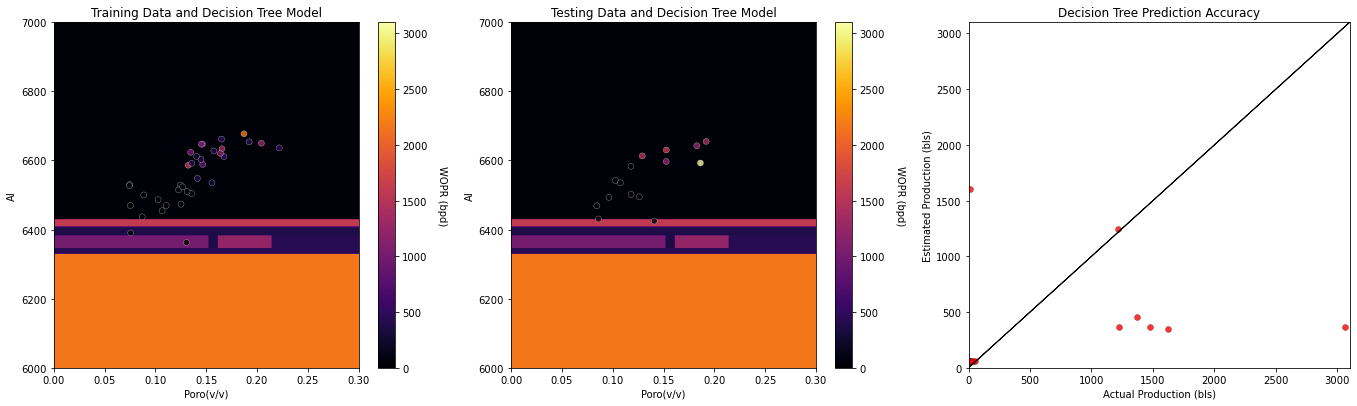

In [302]:
max_leaf_nodes = 10
my_tree = tree.DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes)
#my_tree = tree.DecisionTreeRegressor(max_depth = 3, min_samples_leaf=5)
my_tree = my_tree.fit(X_train, y_train)

plt.subplot(131)
visualize_model(my_tree,X_train["Poro(v/v)"],pormin,pormax,X_train["AI"],AImin,AImax,y_train["WOPR (bpd)"],WOPRmin,WOPRmax,'Training Data and Decision Tree Model')

plt.subplot(132)
visualize_model(my_tree,X_test["Poro(v/v)"],pormin,pormax,X_test["AI"],AImin,AImax,y_test["WOPR (bpd)"],WOPRmin,WOPRmax,'Testing Data and Decision Tree Model')

plt.subplot(133)
check_model(my_tree,X_test["Poro(v/v)"],X_test["AI"],y_test["WOPR (bpd)"],'Decision Tree Prediction Accuracy')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

- **Hyperparameter Tuning**

In [311]:
trees = []
error = []
var_exp = [] 
nodes = []

inodes = 2
while inodes < 375:
    my_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=inodes)
    my_tree = my_tree.fit(X_train, y_train)
    trees.append(my_tree)
    #visualize_tree(my_tree,X_train["Por"],X_train["Brittle"],y_train["Prod"],'Training Data and Decision Tree Model, Nodes = ' + str(inodes) )

    predict_train = my_tree.predict(np.c_[X_test["Poro(v/v)"],X_test["AI"]])
    
    error.append(metrics.mean_squared_error(y_test["WOPR (bpd)"],predict_train))
    var_exp.append(metrics.explained_variance_score(y_test["WOPR (bpd)"],predict_train))    

    all_nodes = my_tree.tree_.node_count             
    decision_nodes = len([x for x in my_tree.tree_.feature if x != _tree.TREE_UNDEFINED]) 
    terminal_nodes = all_nodes - decision_nodes
    nodes.append(terminal_nodes)
    
    inodes+=1

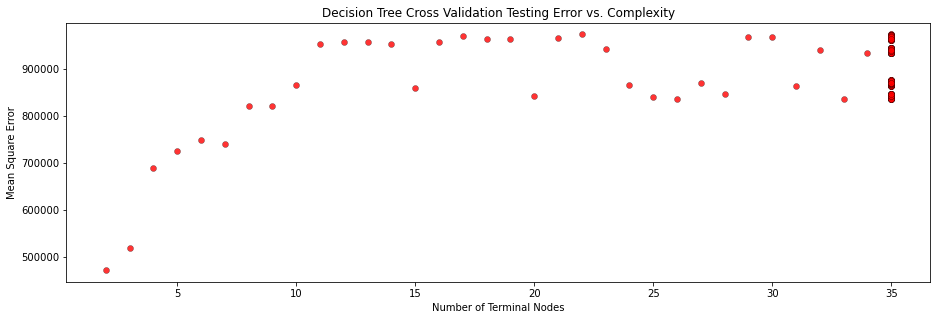

In [312]:
plt.figure(figsize=(8,6))
plt.scatter(nodes,error,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
# plt.arrow(27,0,0,1500000,width=0.5,color='red',head_length=0.0,head_width=0.0)
plt.title('Decision Tree Cross Validation Testing Error vs. Complexity'); plt.xlabel('Number of Terminal Nodes'); plt.ylabel('Mean Square Error')
#plt.xlim(0,375); plt.ylim(0,1500000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.6, wspace=0.2, hspace=0.2)
plt.show()

- **Final Model**

Mean Squared Error on Testing =  37211.51 , Correlation Coefficient =  0.96


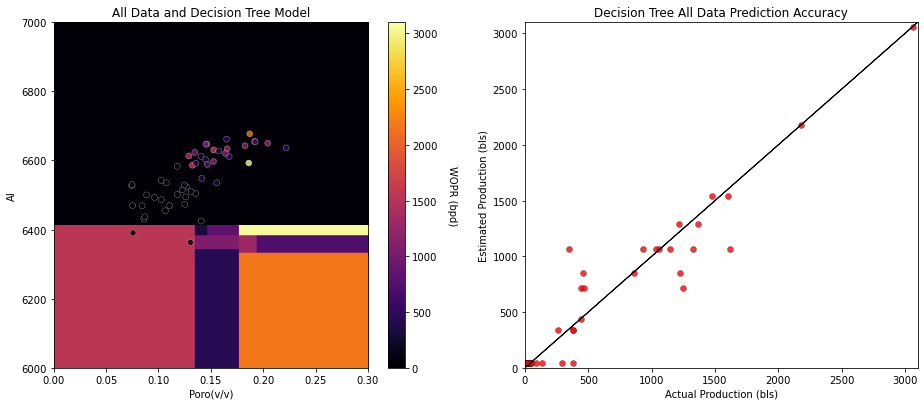

In [314]:
my_pruned_tree = tree.DecisionTreeRegressor(min_samples_leaf=1,max_leaf_nodes=10)
my_pruned_tree = my_pruned_tree.fit(X_all, y_all)

plt.subplot(121)
visualize_model(my_pruned_tree,X_all["Poro(v/v)"],pormin,pormax,X_all["AI"],AImin,AImax,y_all["WOPR (bpd)"],WOPRmin,WOPRmax,'All Data and Decision Tree Model')

plt.subplot(122)
check_model(my_pruned_tree,X_all["Poro(v/v)"],X_all["AI"],y_all["WOPR (bpd)"],'Decision Tree All Data Prediction Accuracy')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [ ]:
88000,125500
88000,134000
87500,131000

In [405]:
wells_df5 = wells_df4.copy()
wells_df5.describe().T

,count,mean,std,min,25%,50%,75%,max
X(ft),50.0,124960.021054,9922.015780,109560.260000,115954.590000,124027.505000,133954.012500,142095.820000
Y(ft),50.0,87617.655277,3297.936805,81792.973846,84687.942500,87780.815000,90481.025000,93691.550000
Completion zone,50.0,0.597692,0.493235,0.000000,0.000000,1.000000,1.000000,1.000000
MD (ft),50.0,4684.640791,152.593498,4293.605683,4578.519247,4680.457700,4793.418005,4978.818183
Poro(v/v),50.0,0.134331,0.035873,0.074403,0.108302,0.133547,0.154945,0.221956
Permeability (mD),50.0,14.957861,20.271745,0.000000,2.615153,7.079680,17.683856,89.126393
AI,50.0,6552.812214,79.439447,6362.714848,6495.933803,6545.065779,6622.551235,6677.045989
WOPR (bpd),50.0,514.362284,686.271526,0.000000,8.873609,194.174395,1007.989810,3060.205978


In [406]:
new_wells_df = pd.read_csv('New_wells.csv', index_col='Well_ID')
new_wells_df.head()

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),AI,WOPR (bpd)
Well_ID,,,,,,,,
Well_50,125500.0,88000.0,NaN,NaN,NaN,NaN,6627.106899,NaN
Well_51,134000.0,88000.0,NaN,NaN,NaN,NaN,6591.075685,NaN
Well_52,131000.0,87500.0,NaN,NaN,NaN,NaN,6609.567000,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [407]:
all_wells_df = pd.concat([wells_df5, new_wells_df])
all_wells_df.head(53)

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),AI,WOPR (bpd)
Well_ID,,,,,,,,
Well_0,137106.820000,83818.470000,0.000000,4659.791739,0.074403,3.098397,6527.288321,8.809168
Well_1,132460.980000,85832.770000,0.000000,4868.900545,0.126777,13.832289,6523.526063,38.675641
Well_10,134042.860000,82411.270000,0.000000,4749.294657,0.125236,2.528347,6473.198759,46.363101
Well_11,115725.490000,86866.600000,0.000000,4628.309023,0.085998,0.635944,6430.629923,0.000000
Well_12,133136.980000,93691.550000,1.000000,4821.390995,0.130572,2.760318,6362.714848,0.664632
Well_13,119311.270000,89234.020000,0.000000,4456.551055,0.107536,0.164326,6535.346304,22.342583
Well_14,134837.260000,83865.820000,1.000000,4850.482978,0.144893,6.240244,6602.638484,381.194628
Well_15,109560.260000,86833.620000,1.000000,4478.001183,0.186269,77.964122,6592.567556,3060.205978
Well_16,112898.580000,91601.460000,1.000000,4628.528038,0.152577,14.217419,6597.023095,1221.216449


In [408]:
df_knn = all_wells_df.copy(deep=True)   # make a deep copy of the DataFrame
knn_imputer = KNNImputer(n_neighbors=4, weights="distance")
df_knn.iloc[:,:] = knn_imputer.fit_transform(df_knn)

In [409]:
all_wells_df['Poro(v/v)'] = df_knn['Poro(v/v)']
all_wells_df['Completion zone'] = df_knn['Completion zone']
all_wells_df[' MD (ft)'] = df_knn[' MD (ft)']
all_wells_df['Permeability (mD)	'] = df_knn['Permeability (mD)']
all_wells_df['WOPR (bpd)'] = df_knn['WOPR (bpd)']

# all_wells_df.describe().T
all_wells_df.head(53)

,X(ft),Y(ft),Completion zone,MD (ft),Poro(v/v),Permeability (mD),AI,WOPR (bpd),Permeability (mD)\t
Well_ID,,,,,,,,,
Well_0,137106.820000,83818.470000,0.000000,4659.791739,0.074403,3.098397,6527.288321,8.809168,3.098397
Well_1,132460.980000,85832.770000,0.000000,4868.900545,0.126777,13.832289,6523.526063,38.675641,13.832289
Well_10,134042.860000,82411.270000,0.000000,4749.294657,0.125236,2.528347,6473.198759,46.363101,2.528347
Well_11,115725.490000,86866.600000,0.000000,4628.309023,0.085998,0.635944,6430.629923,0.000000,0.635944
Well_12,133136.980000,93691.550000,1.000000,4821.390995,0.130572,2.760318,6362.714848,0.664632,2.760318
Well_13,119311.270000,89234.020000,0.000000,4456.551055,0.107536,0.164326,6535.346304,22.342583,0.164326
Well_14,134837.260000,83865.820000,1.000000,4850.482978,0.144893,6.240244,6602.638484,381.194628,6.240244
Well_15,109560.260000,86833.620000,1.000000,4478.001183,0.186269,77.964122,6592.567556,3060.205978,77.964122
Well_16,112898.580000,91601.460000,1.000000,4628.528038,0.152577,14.217419,6597.023095,1221.216449,14.217419


## MODEL PREDICTION FOR NEW WELLS - OIL RATE (bpd)

In [420]:
from sklearn import tree                                                  # import decision tree from scikit-learn
# my_data = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv") # load subsurface data table
my_tree = tree.DecisionTreeRegressor(min_samples_leaf=1, max_depth = 10)   # instantiate tree with hyperparameters
# my_tree = my_tree.fit(all_wells_df[['Poro(v/v)','AI']],all_wells_df['WOPR (bpd)'])   # train tree with training data
my_tree = my_tree.fit(wells_df5[['Poro(v/v)','AI']],wells_df5['WOPR (bpd)'])   # train tree with training data
est_prod1 = my_tree.predict([[0.130085,6627.106899]])[0]                              # make a prediction (no tuning shown)
est_prod2 = my_tree.predict([[0.147142,6591.075685]])[0]                              # make a prediction (no tuning shown)
est_prod3 = my_tree.predict([[0.116,6690]])[0]                              # make a prediction (no tuning shown)
print('Well 50 - Estimated production for Porosity  and AI is ' + str(round(est_prod1,1)) + ' (bpd).')
print('Well 51 - Estimated production for Porosity  and AI is ' + str(round(est_prod2,1)) + ' (bpd).')
print('Well 52 - Estimated production for Porosity  and AI is ' + str(round(est_prod3,1)) + ' (bpd).')

Well 50 - Estimated production for Porosity  and AI is 1475.9 (bpd).
Well 51 - Estimated production for Porosity  and AI is 859.5 (bpd).
Well 52 - Estimated production for Porosity  and AI is 1475.9 (bpd).


In [422]:
Total_prod_well_50 = 1475.9*365*2
Total_prod_well_51 = 859.5*365*2
Total_prod_well_52 = 1475.9*365*2
print(Total_prod_well_50, '(bls)')
print(Total_prod_well_51, '(bls)')
print(Total_prod_well_52, '(bls)')


1077407.0 (bls)
627435.0 (bls)
1077407.0 (bls)
